In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Sean\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


In [27]:
# test for stationarity

from statsmodels.tsa.stattools import adfuller
adfuller(yen_futures.Settle)

# 2nd value is pvalue - below .05% would be stationary- this isn't

(-2.4151247020844746,
 0.13751299771595027,
 0,
 7514,
 {'1%': -3.431220579634037,
  '5%': -2.861924730395352,
  '10%': -2.566974787574595},
 83512.35174961216)

 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

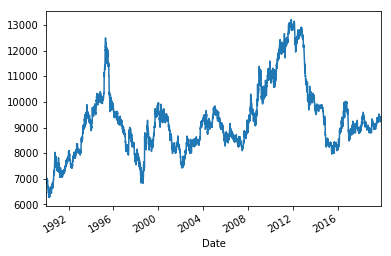

In [5]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!

settle_plot  =  yen_futures.Settle.plot()

# There is certainly some upward trend - albeit very gradual - may require first differencing/pct_change

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!

settle_price_noise, settle_price_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000013764636D08>,
      dtype=object)

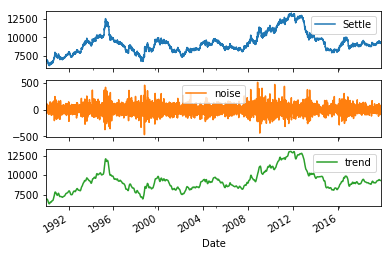

In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!

settle_price_noise = pd.DataFrame(settle_price_noise)
settle_price_trend= pd.DataFrame(settle_price_trend)

new_frame = pd.DataFrame(yen_futures['Settle'])

yen_frame = pd.concat([new_frame,settle_price_noise,settle_price_trend], axis = 1, join = 'inner').dropna()

yen_frame.columns = columns = ['Settle','noise','trend']

yen_frame.plot(subplots = True)

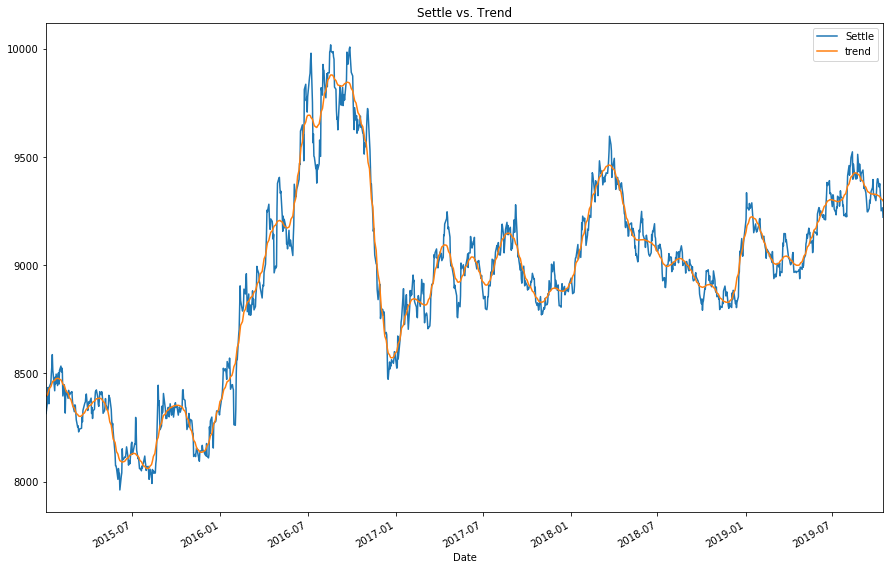

In [8]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!


yen_frame.loc["2015-01-01":,][['Settle','trend']].plot(title = 'Settle vs. Trend', figsize = (15,10))

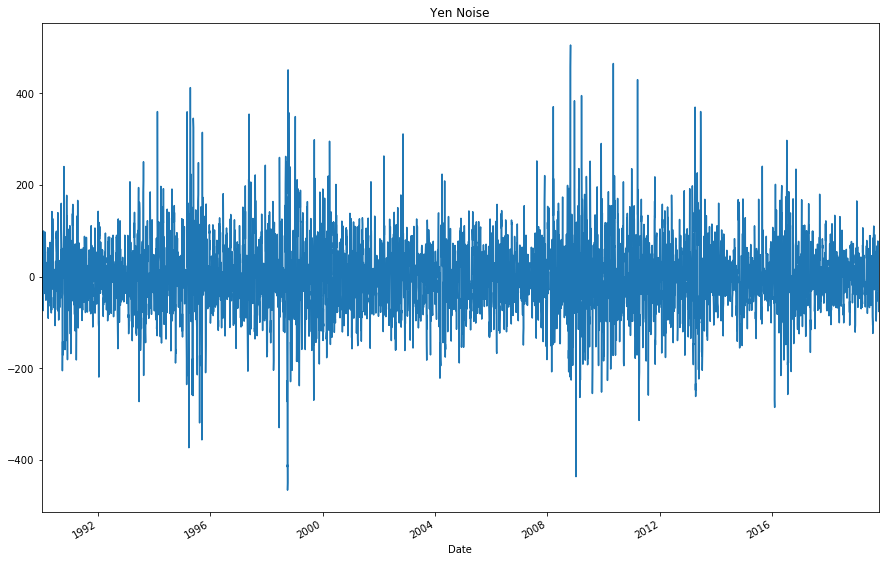

In [9]:
# Plot the Settle Noise
# YOUR CODE HERE!

yen_frame['noise'].plot(title= 'Yen Noise',figsize = (15,10))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()
returns.head()

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275


In [11]:
import statsmodels.api as sm

# Import the ARMA model
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!

model_2_1 = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!

results = model_2_1.fit()

C:\Users\Sean\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [13]:
# Output model summary results:
# YOUR CODE HERE!

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 25 Feb 2021   AIC                          15798.142
Time:                        16:08:09   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3064      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2949      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3326           +0.0000j            3.3326            0.5000
AR.2         -157.0960           +0.0000j          157.0960            0.5000
MA.1           -3.3914           +0.0000j            3.3914            0.5000
-----------------------------------------------------------------------------
"""

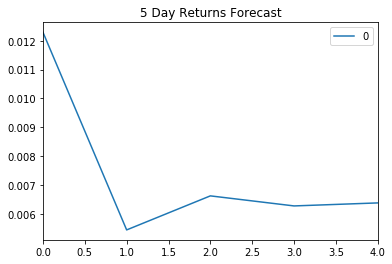

In [14]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!

pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [15]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!

from statsmodels.tsa.arima_model import ARIMA
arima_5_1_1 = ARIMA(yen_frame['Settle'], order=(5, 1, 1))

# Fit the model
# YOUR CODE HERE!

results_2 = arima_5_1_1.fit()

C:\Users\Sean\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sean\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it h

In [16]:
# Output model summary results:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 25 Feb 2021   AIC                          83905.238
Time:                        16:08:30   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.668       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8918           -1.3787j            2.3409           -0.1002
AR.2            1.8918           +1.3787j            2.3409            0.1002
AR.3           -2.2705           -3.0203j            3.7785           -0.3526
AR.4           -2.2705           +3.0203j            3.7785            0.3526
AR.5          -11.0834           -0.0000j           11.0834           -0.5000
MA.1            3.3643           +0.0000j            3.3643            0.0000
-----------------------------------------------------------------------------
"""

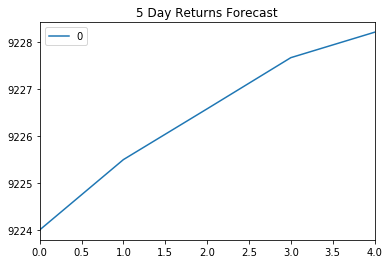

In [17]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!

pd.DataFrame(results_2.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

It would appear that both models do a poor job of predicting yen futures.  This would need further inspection as to why that is happening.  It seems like p values aren't significant in either model.  I would imagine yen futures are more 'noise/random walk' oriented.  Also, I'd imagine most of the read-through comes from the data on the first lag.  This would require further inspection however.  I'm not sure selecting 2,1 and 5,1,1 models makes sense from the word 'go'.  I would have gone through a few model inspections in order to ascertain if there is any value in forecasting JPY futures in any case.  Below I do some inspection.  I'm not sure if this is what we were supposed to do, but since the other two models appear to be garbage, and we haven't really done a full level inspection ahead of selecting 2,1 or 5,1,1 respectively - might be worth an ACF DCF and some other tools being used to see if we are missing something.   

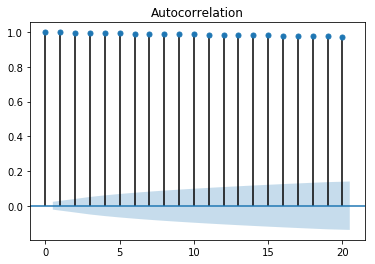

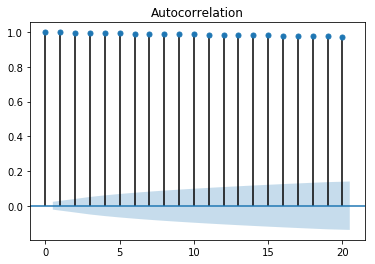

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(yen_futures['Settle'], lags=20)

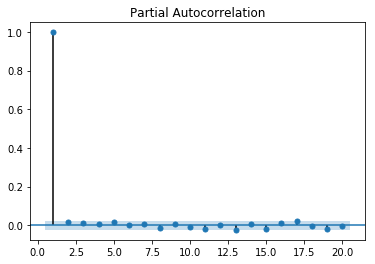

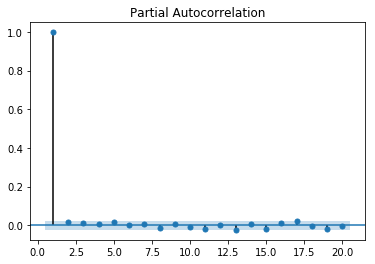

In [19]:
plot_pacf(yen_futures['Settle'], zero=False, lags=20)

The problem seems to be that all the data for the model is in the first lag.  This might be more of a complete random walk?  

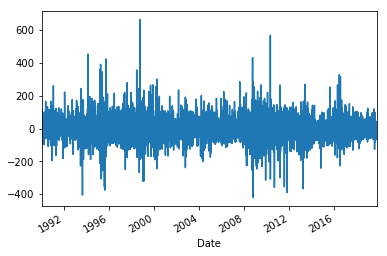

In [22]:
test_df = yen_futures.Settle.diff().dropna()

test_df.plot()

# this seems stationary- but should do a test? 

In [20]:
# trying one more thing - do a % change on 'settle' and see if we can generate something meaningful with a simple AR model 

test_df = yen_futures.Settle.diff().dropna()

simple_model = ARMA(test_df.values, order=(1,1))

simple_model_fitted = simple_model.fit()

simple_model_fitted.summary()

C:\Users\Sean\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(1, 1)   Log Likelihood              -41945.752
Method:                       css-mle   S.D. of innovations             64.290
Date:                Thu, 25 Feb 2021   AIC                          83899.504
Time:                        16:08:59   BIC                          83927.202
Sample:                             0   HQIC                         83909.014
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3160      0.705      0.448      0.654      -1.066       1.698
ar.L1.y        0.6786      0.174      3.905      0.000       0.338       1.019
ma.L1.y       -0.6943      0.170     -4.081      0.000      -1.028      -0.361
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4736           +0.0000j            1.4736            0.0000
MA.1            1.4402           +0.0000j            1.4402            0.0000
-----------------------------------------------------------------------------
"""

Again - not sure what to make of this - low pvalue for our lag one MA - but not sure we really know if this is a 'good' model, given the AIC and BIC went up. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [39]:
from arch import arch_model

In [40]:
# Estimate a GARCH model:
# YOUR CODE HERE!

# 'p' and 'q'  are akin to the 'p' and 'q' of an ARMA model.
# 'vol="GARCH"' means that we're using a GARCH model.
# The 'mean="Zero"' means that we're estimating a GARCH.
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
# YOUR CODE HERE!

res = model.fit(disp="off")

In [41]:
# Summarize the model results
# YOUR CODE HERE!

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Thu, Feb 25 2021   Df Residuals:                     7514
Time:                        17:18:02   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [42]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [43]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!

forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [44]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [45]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15 00:00:00
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


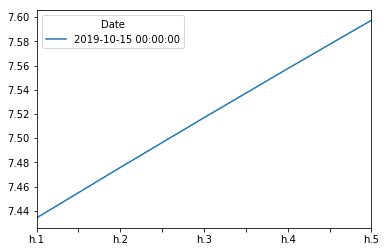

In [46]:
# Plot the final forecast
# YOUR CODE HERE!

final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

Ultimately I don't feel a high degree of confidence in the models informing me to buy yen.  My conclusion is that the models are not tradeable, and that while vol (risk) is expected to increase - we might be better at trading this conclusion/forecast given the output of the models in terms of p values / AIC / BIC 